In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
%cd /content/drive/MyDrive/cxr_data/

/content/drive/MyDrive/cxr_data


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import sklearn

In [6]:
import glob
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input

In [7]:
train_labels_path = "/content/drive/MyDrive/cxr_data/train_labels.csv"
train_labels_df = pd.read_csv(train_labels_path, names=['label'])
train_labels = train_labels_df['label'].tolist()

In [9]:
test_labels_path = "/content/drive/MyDrive/cxr_data/test_labels.csv"
test_labels_df = pd.read_csv(test_labels_path, names=['label'])
test_labels = test_labels_df['label'].tolist()

In [10]:
val_labels_path = "/content/drive/MyDrive/cxr_data/val_labels.csv"
val_labels_df = pd.read_csv(val_labels_path, names=['label'])
val_labels = val_labels_df['label'].tolist()

In [11]:
train_images = glob.glob('/content/drive/MyDrive/cxr_data/train/*jpeg')
test_images = glob.glob('/content/drive/MyDrive/cxr_data/test/*jpeg')
val_images = glob.glob('/content/drive/MyDrive/cxr_data/val/*jpeg')

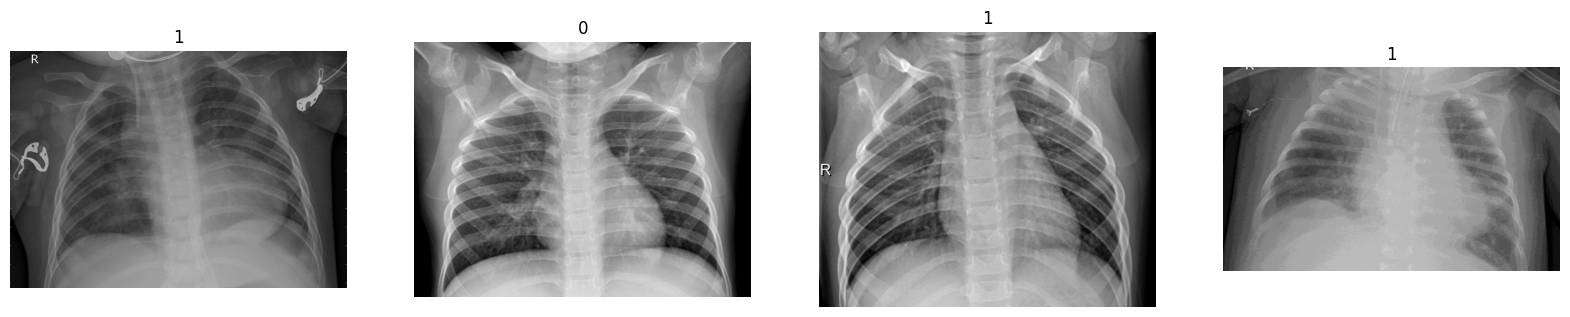

In [12]:
plt.figure(figsize=(20,4))
for i in enumerate(train_images[0:4]):
    idx = i[0]
    plt.subplot(1,4,idx+1)
    plt.axis('off')
    image = plt.imread(i[1])
    plt.imshow(image, cmap='gray')
    plt.title(str(train_labels[idx]))

In [13]:
def process_image(image_path, label):
    image_path = image_path.decode()
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255
    img = img.astype('float32')
    return img, label

In [14]:
def create_dataset(paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(lambda x, y: tuple(tf.numpy_function(process_image, [x, y], [tf.float32, tf.int32])))
    return dataset.batch(8)

train_dataset = create_dataset(train_images, train_labels)
val_dataset = create_dataset(val_images, val_labels)
test_dataset = create_dataset(test_images, test_labels)

In [16]:
base_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    input_tensor=Input(shape=(224,224,3)),
)
base_model.trainable = True

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 14739777 (56.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
num_epochs = 10
model_path = "model.h5"
log_dir = "log_dir"

callbacks = [
    ModelCheckpoint(model_path, verbose=2, save_best_only=True),
    TensorBoard(log_dir=log_dir, histogram_freq=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=False),
]

In [19]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/10
652/652 [==============================] - ETA: 0s - loss: 0.5938
Epoch 1: val_loss improved from inf to 0.81842, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


652/652 [==============================] - 3401s 5s/step - loss: 0.5938 - val_loss: 0.8184 - lr: 1.0000e-04
Epoch 2/10
652/652 [==============================] - ETA: 0s - loss: 0.5793
Epoch 2: val_loss did not improve from 0.81842
652/652 [==============================] - 176s 270ms/step - loss: 0.5793 - val_loss: 0.9678 - lr: 1.0000e-04
Epoch 3/10
652/652 [==============================] - ETA: 0s - loss: 0.5778
Epoch 3: val_loss improved from 0.81842 to 0.80981, saving model to model.h5
652/652 [==============================] - 181s 276ms/step - loss: 0.5778 - val_loss: 0.8098 - lr: 1.0000e-04
Epoch 4/10
652/652 [==============================] - ETA: 0s - loss: 0.5832
Epoch 4: val_loss improved from 0.80981 to 0.79955, saving model to model.h5
652/652 [==============================] - 180s 276ms/step - loss: 0.5832 - val_loss: 0.7996 - lr: 1.0000e-04
Epoch 5/10
652/652 [==============================] - ETA: 0s - loss: 0.5763
Epoch 5: val_loss did not improve from 0.79955
652/65

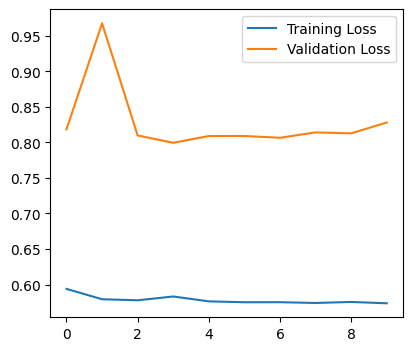

In [24]:
# acc = history.history['acc']
# val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.plot(num_epochs, acc, label='Training Accuracy')
# plt.plot(num_epochs, acc, label='Validation Accuracy')
# plt.legend(loc='lower right')

plt.subplot(1,2,1)
plt.plot(range(num_epochs), loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [25]:
preds = model.predict(test_dataset)

78/78 [==============================] - 416s 5s/step


In [44]:
training_preds = model.predict(train_dataset)

652/652 [==============================] - 159s 244ms/step


In [45]:
predictions = [1 if x > 0.5 else 0 for x in training_preds]

In [47]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(train_labels, predictions)

In [48]:
accuracy

0.7429064417177914